In [69]:
from deepface import DeepFace
from matplotlib import pyplot as plt
import cv2
import numpy as np
import mediapipe as mp
import supervision as sv
import os

## Getting the reference image

In [ ]:
REFERENCE_IMAGE = "reference_image.jpg"
REFERENCE_IMAGE_PATH = os.path.abspath(os.path.join('..', 'data', 'test_images', REFERENCE_IMAGE))

In [ ]:
TEST_IMAGE = "test_image6.png"
TEST_IMAGE_PATH = os.path.abspath(os.path.join('..', 'data', 'test_images', TEST_IMAGE))

In [72]:
face_objs = DeepFace.extract_faces(
    img_path=REFERENCE_IMAGE_PATH,
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

In [73]:
OUTPUT_SIZE = (200, 200)

def fit_to_output_size(frame: np.ndarray) -> np.ndarray:
    """
    Resize a frame to the output size.
    """
    return cv2.resize(frame, OUTPUT_SIZE)

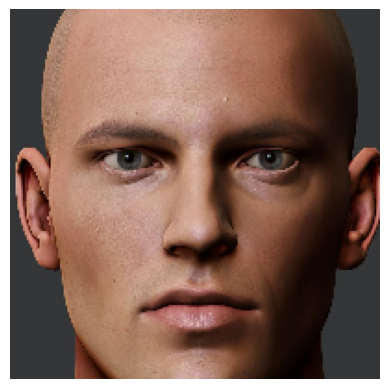

In [74]:
face = face_objs[0]["face"]
face_recolored = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
frame = fit_to_output_size(face_recolored)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [75]:
VERTEX_COLOR = sv.Color.WHITE
VERTEX_RADIUS = 1

model = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=False,       # Set to True if working with still images
    refine_landmarks=True,         # Enables more precise landmark detection (includes irises)
    max_num_faces=1,               # Number of faces to detect
    min_detection_confidence=0.5,  # Minimum detection confidence
    min_tracking_confidence=0.5,   # Minimum tracking confidence
)
annotator = sv.VertexAnnotator(color=VERTEX_COLOR, radius=VERTEX_RADIUS)

In [76]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)

In [77]:
def get_xyz_from_processed_frame(processed_frame):
    results = [
                face_landmark.landmark
                for face_landmark in processed_frame.multi_face_landmarks
            ]

    xyz = []
    for pose in results:
        prediction_xyz = []
        prediction_confidence = []
        for landmark in pose:
            keypoint_xyz = [
                landmark.x,
                landmark.y,
                landmark.z,  # z-coordinate (relative to camera in meters) scaled to image width
            ]
            prediction_xyz.append(keypoint_xyz)
            prediction_confidence.append(landmark.visibility)

        xyz.append(prediction_xyz)

    return xyz

In [78]:
def get_scaled_xy_from_xyz(xyz):
    xy = [[x, y] for (x, y, _) in xyz]

    return np.array(xy)

In [79]:
get_xyz_from_processed_frame(processed_frame)

[[[0.5001113414764404, 0.7650076746940613, -0.08616425096988678],
  [0.5212745666503906, 0.6404224038124084, -0.18515141308307648],
  [0.5178398489952087, 0.672256350517273, -0.08973998576402664],
  [0.4902147948741913, 0.5195964574813843, -0.15003225207328796],
  [0.5219776630401611, 0.6045880317687988, -0.20005254447460175],
  [0.5215024948120117, 0.5555898547172546, -0.18996550142765045],
  [0.5192314386367798, 0.4357013702392578, -0.11048006266355515],
  [0.2636278569698334, 0.41810160875320435, 0.02247174084186554],
  [0.5199131369590759, 0.3630450665950775, -0.09985034167766571],
  [0.5208133459091187, 0.31766775250434875, -0.11358114331960678],
  [0.5219904184341431, 0.10784459114074707, -0.0914636105298996],
  [0.5008569359779358, 0.7774296998977661, -0.0803573951125145],
  [0.5017540454864502, 0.7899869680404663, -0.06708497554063797],
  [0.5029942989349365, 0.7987955212593079, -0.044967085123062134],
  [0.502235472202301, 0.7994415163993835, -0.0413089282810688],
  [0.5026647

In [80]:
np.save('key_points_xyz.npy', get_xyz_from_processed_frame(processed_frame))

In [81]:
loaded_key_points = np.load('key_points_xyz.npy')
print(loaded_key_points)

[[[ 0.50011134  0.76500767 -0.08616425]
  [ 0.52127457  0.6404224  -0.18515141]
  [ 0.51783985  0.67225635 -0.08973999]
  ...
  [ 0.7017175   0.37247342  0.0175188 ]
  [ 0.66567492  0.40137383  0.0175188 ]
  [ 0.69971848  0.43041158  0.0175188 ]]]


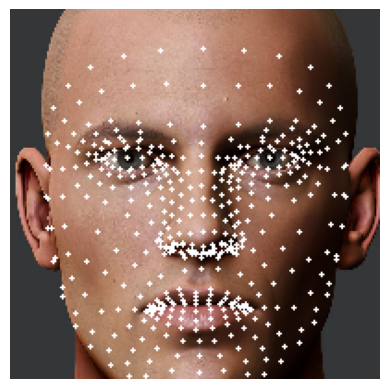

In [82]:
out_frame = annotator.annotate(frame, key_points)
plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Get the face for frontalization

In [38]:
face_objs = DeepFace.extract_faces(
    img_path=TEST_IMAGE_PATH,
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

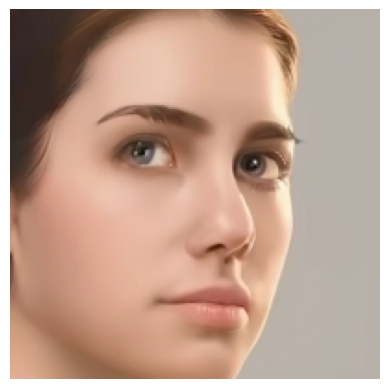

In [39]:
face = face_objs[0]["face"]
face_recolored = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
frame = fit_to_output_size(face_recolored)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [40]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)
key_points.xy = key_points.xy[:1]

In [41]:
image_to_frontalize_xyz = get_xyz_from_processed_frame(processed_frame)
image_to_frontalize_xyz

[[[0.5917298793792725, 0.7547014355659485, -0.09920568764209747],
  [0.6356902122497559, 0.6296242475509644, -0.15331487357616425],
  [0.5936328172683716, 0.6710850596427917, -0.08498650789260864],
  [0.5909451246261597, 0.5166795253753662, -0.12336286157369614],
  [0.6411898136138916, 0.5938392877578735, -0.16087231040000916],
  [0.6317259073257446, 0.5496121644973755, -0.14587914943695068],
  [0.5964993238449097, 0.4419041872024536, -0.05842651426792145],
  [0.31604743003845215, 0.4011603891849518, -0.06795650720596313],
  [0.5920946002006531, 0.35284221172332764, -0.03190908581018448],
  [0.5995475649833679, 0.3051742613315582, -0.03373828902840614],
  [0.5989843010902405, 0.12783795595169067, 0.018962187692523003],
  [0.5899995565414429, 0.7698791027069092, -0.09652774035930634],
  [0.5841313600540161, 0.7856535911560059, -0.08657190203666687],
  [0.5766326785087585, 0.7962309122085571, -0.07196598500013351],
  [0.577272355556488, 0.7957427501678467, -0.07833091169595718],
  [0.579

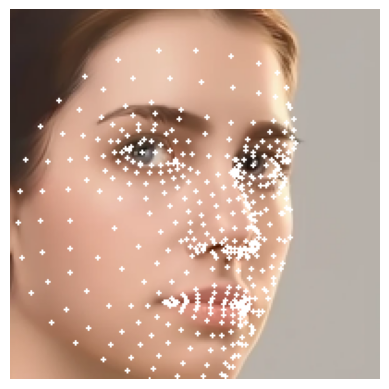

In [42]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Frontalization

In [43]:
face_to_frontalize_keypoints = np.array(image_to_frontalize_xyz)
reference_keypoints = np.load('key_points_xyz.npy')

print("Shape of face_to_frontalize_keypoints:", face_to_frontalize_keypoints.shape)
print("Shape of reference_keypoints:", reference_keypoints.shape)

Shape of face_to_frontalize_keypoints: (1, 478, 3)
Shape of reference_keypoints: (1, 478, 3)


### AffinePartial3D

In [44]:
# Estimate the affine transformation
retval, matrix, inliers = cv2.estimateAffine3D(face_to_frontalize_keypoints[0], reference_keypoints[0])
frontalized_keypoints = cv2.transform(face_to_frontalize_keypoints, matrix)[0]

### Procrustes Analysis

In [45]:
def procrustes_analysis(X, Y):
    """
    Perform Procrustes analysis to align X to Y.
    X and Y are expected to have shape (N, 3) where N is the number of keypoints.
    """
    # Subtract the centroid (mean) of the points
    X_mean = np.mean(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    
    X_centered = X - X_mean
    Y_centered = Y - Y_mean
    
    # Normalize the points (scaling to unit variance)
    X_norm = np.linalg.norm(X_centered)
    Y_norm = np.linalg.norm(Y_centered)
    
    X_centered /= X_norm
    Y_centered /= Y_norm
    
    # Compute the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(np.dot(X_centered.T, Y_centered))
    R = np.dot(U, Vt)
    
    # Apply the rotation matrix to X
    X_aligned = np.dot(X_centered, R)
    
    # Rescale and shift X_aligned back to original scale and position
    X_aligned = X_aligned * Y_norm + Y_mean
    
    return X_aligned

frontalized_keypoints = procrustes_analysis(face_to_frontalize_keypoints[0], reference_keypoints[0])

## Frontalized visualization

In [46]:
frontalized_keypoints = get_scaled_xy_from_xyz(frontalized_keypoints)
face_to_frontalize_keypoints = get_scaled_xy_from_xyz(face_to_frontalize_keypoints[0])
reference_keypoints = get_scaled_xy_from_xyz(reference_keypoints[0])

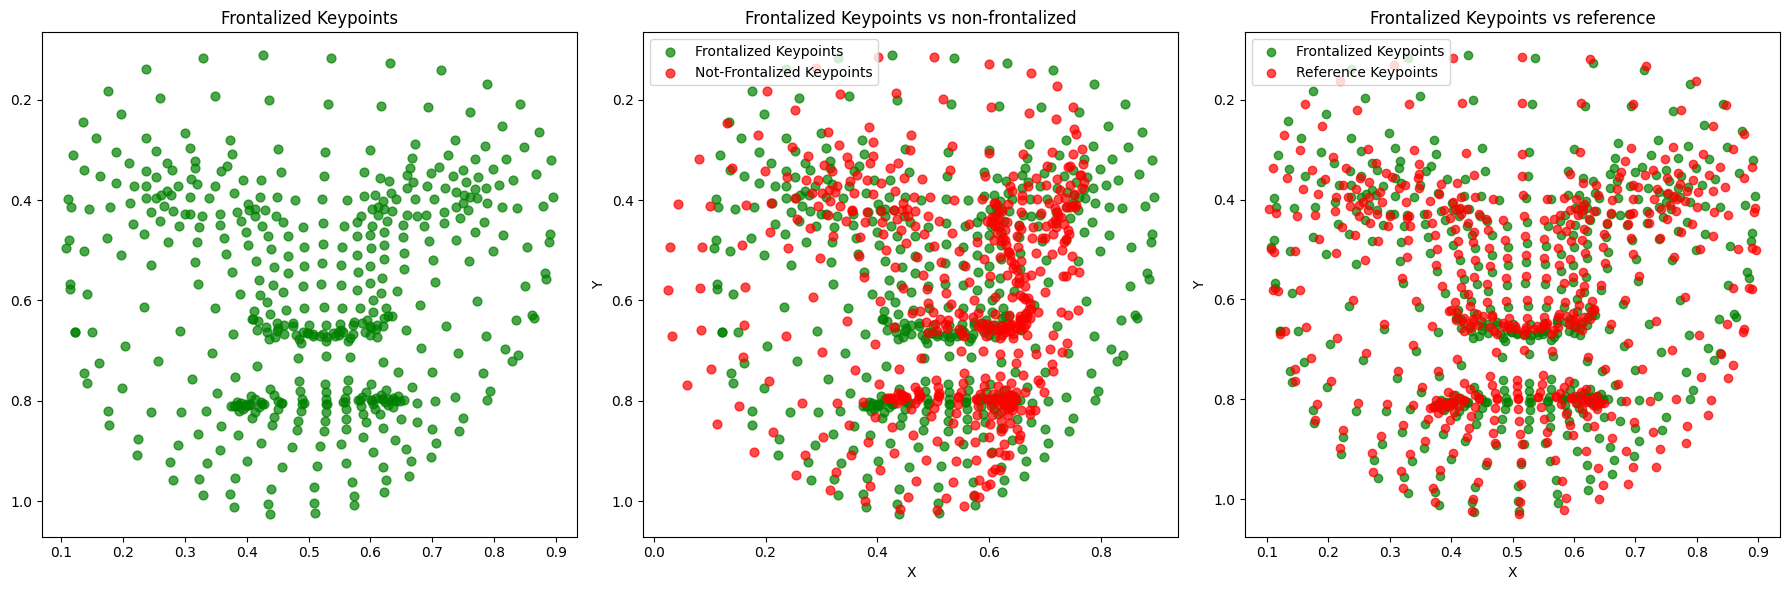

In [50]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size for better spacing

# Just frontalized
plt.subplot(1, 3, 1)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs non-frontalized
plt.subplot(1, 3, 2)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.scatter(face_to_frontalize_keypoints[:, 0], face_to_frontalize_keypoints[:, 1], 
            color='red', label='Not-Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints vs non-frontalized')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs Reference
plt.subplot(1, 3, 3)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7)

plt.scatter(reference_keypoints[:, 0], reference_keypoints[:, 1], 
            color='red', label='Reference Keypoints', alpha=0.7)

plt.title(f'Frontalized Keypoints vs reference')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()